In [1]:
# ======================================================
# 1) Introdução
# ======================================================
# Este notebook foi preparado para ser executado no Google Colab.
# Objetivo: treinar um modelo de Machine Learning (ex.: Rede Neural)
# para prever o valor mediano de casas na Califórnia.
#
# Dataset: California Housing (scikit-learn)
#
# Fluxo:
#   1. Carregar dataset
#   2. Dividir em treino/teste
#   3. Pré-processamento com ColumnTransformer
#   4. Baseline com DummyRegressor
#   5. Treinar seu modelo de ML (ex.: Rede Neural MLP)
#   6. Avaliar métricas (MAE, RMSE, R²)
#   7. Adicione PCA ao código e treine novamente o modelo de Rede Neural.

In [2]:
# ======================================================
# 2) Imports e Configurações
# ======================================================

import os
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")

# Semente para reprodutibilidade
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


In [3]:
# ======================================================
# 3) Funções Auxiliares
# ======================================================

def load_california_housing():
    """
    Carrega o dataset California Housing como DataFrame.
    Retorna X, y, lista de colunas numéricas e categóricas.
    """
    ds = fetch_california_housing(as_frame=True)
    frame = ds.frame.copy()
    y = frame["MedHouseVal"]
    X = frame.drop(columns=["MedHouseVal"])
    numeric_features = X.columns.tolist()
    categorical_features = []  # não há colunas categóricas
    return X, y, numeric_features, categorical_features


def build_preprocessor(numeric_features, categorical_features):
    """
    Cria o pré-processador:
      - Numéricas: imputação de mediana + padronização
      - Categóricas: (não usado aqui, mas estrutura mantida para exemplos futuros)
    """
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
        ]
    )
    return preprocessor


def evaluate(model, X_test, y_test, label="Modelo"):
    """
    Avalia o modelo no conjunto de teste e retorna métricas (MAE, RMSE, R²).
    Compatível com versões antigas do scikit-learn.
    """
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))  # corrigido
    r2 = r2_score(y_test, preds)
    print(f"[{label}]  MAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def analyze_pca_variance(X_train, n_components=None):
    """
    Analisa a variância explicada pelo PCA e retorna o número de componentes
    necessários para manter 95% da variância.
    """
    # Aplicar PCA para análise de variância
    pca_full = PCA()
    pca_full.fit(X_train)
    
    # Calcular variância cumulativa
    cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
    
    # Encontrar número de componentes para 95% da variância
    n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
    
    print(f"Análise de Variância PCA:")
    print(f"- Total de features: {X_train.shape[1]}")
    print(f"- Componentes para 95% variância: {n_components_95}")
    print(f"- Redução dimensional: {((X_train.shape[1] - n_components_95) / X_train.shape[1]) * 100:.1f}%")
    
    # Visualizar variância explicada
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
             pca_full.explained_variance_ratio_, 'bo-')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Variância Explicada')
    plt.title('Variância Explicada por Componente')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'ro-')
    plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variância')
    plt.axvline(x=n_components_95, color='g', linestyle='--', alpha=0.7)
    plt.xlabel('Número de Componentes')
    plt.ylabel('Variância Cumulativa')
    plt.title('Variância Cumulativa')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return n_components_95 if n_components is None else n_components



In [4]:
# ======================================================
# 4) Carregar Dados e Split
# ======================================================

X, y, num_feats, cat_feats = load_california_housing()
print(f"Dataset carregado. X shape={X.shape} | y shape={y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED
)


Dataset carregado. X shape=(20640, 8) | y shape=(20640,)


In [5]:
# ======================================================
# 5) Baseline (DummyRegressor)
# ======================================================

preprocessor = build_preprocessor(num_feats, cat_feats)

baseline = Pipeline(steps=[
    ("pre", preprocessor),
    ("reg", DummyRegressor(strategy="median"))
])

baseline.fit(X_train, y_train)
evaluate(baseline, X_test, y_test, label="Baseline (Dummy)")


[Baseline (Dummy)]  MAE=0.8740 | RMSE=1.1731 | R²=-0.0502


{'MAE': 0.8740399224806202,
 'RMSE': 1.1731167105035603,
 'R2': -0.050208628996205595}

ANÁLISE DE PCA - CALIFORNIA HOUSING
Análise de Variância PCA:
- Total de features: 8
- Componentes para 95% variância: 6
- Redução dimensional: 25.0%


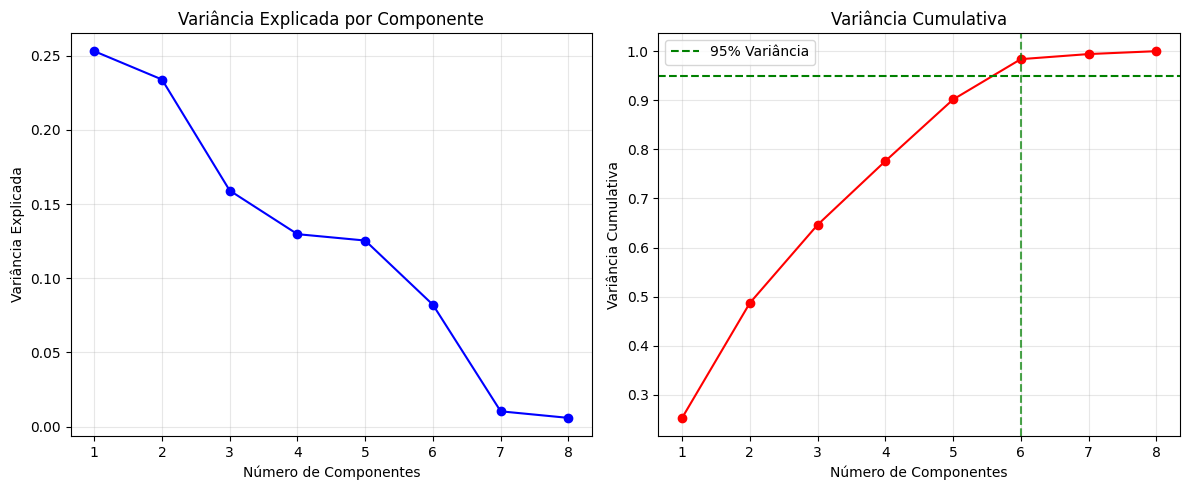


COMPARAÇÃO DE MODELOS MLPRegressor

🔵 MODELO SEM PCA:
Validação Cruzada R² (média ± desvio): 0.7696 ± 0.0083
[MLP SEM PCA]  MAE=0.3675 | RMSE=0.5428 | R²=0.7752

🟢 MODELO COM PCA:
Validação Cruzada R² (média ± desvio): 0.6853 ± 0.0035
[MLP COM PCA]  MAE=0.4609 | RMSE=0.6455 | R²=0.6821


In [6]:
# ======================================================
# 6) Análise de PCA e Comparação de Modelos
# ======================================================

# Primeiro, vamos analisar a variância explicada pelo PCA
print("=" * 60)
print("ANÁLISE DE PCA - CALIFORNIA HOUSING")
print("=" * 60)

# Aplicar pré-processamento para análise de PCA
X_train_processed = preprocessor.fit_transform(X_train)
n_components_optimal = analyze_pca_variance(X_train_processed)

print("\n" + "=" * 60)
print("COMPARAÇÃO DE MODELOS MLPRegressor")
print("=" * 60)

# ======================================================
# 6.1) Modelo SEM PCA
# ======================================================
print("\n🔵 MODELO SEM PCA:")
model_without_pca = Pipeline(steps=[
    ("pre", preprocessor),
    ("reg", MLPRegressor(hidden_layer_sizes=(12, 6),
                         activation="relu",
                         learning_rate_init=0.001,
                         max_iter=800,
                         random_state=RANDOM_SEED))
])

# Validação cruzada
cv_scores_without_pca = cross_val_score(model_without_pca, X_train, y_train, cv=5, scoring="r2")
print(f"Validação Cruzada R² (média ± desvio): {cv_scores_without_pca.mean():.4f} ± {cv_scores_without_pca.std():.4f}")

# Treino final
model_without_pca.fit(X_train, y_train)
metrics_without_pca = evaluate(model_without_pca, X_test, y_test, label="MLP SEM PCA")

# ======================================================
# 6.2) Modelo COM PCA
# ======================================================
print("\n🟢 MODELO COM PCA:")
model_with_pca = Pipeline(steps=[
    ("pre", preprocessor),
    ("pca", PCA(n_components=n_components_optimal, random_state=RANDOM_SEED)),
    ("reg", MLPRegressor(hidden_layer_sizes=(12, 6),
                         activation="relu",
                         learning_rate_init=0.001,
                         max_iter=800,
                         random_state=RANDOM_SEED))
])

# Validação cruzada
cv_scores_with_pca = cross_val_score(model_with_pca, X_train, y_train, cv=5, scoring="r2")
print(f"Validação Cruzada R² (média ± desvio): {cv_scores_with_pca.mean():.4f} ± {cv_scores_with_pca.std():.4f}")

# Treino final
model_with_pca.fit(X_train, y_train)
metrics_with_pca = evaluate(model_with_pca, X_test, y_test, label="MLP COM PCA")



RESUMO COMPARATIVO DOS RESULTADOS
          Modelo      MAE     RMSE        R² CV R² (média) CV R² (std)
Baseline (Dummy) 0.874000 1.173100 -0.050200           N/A         N/A
     MLP SEM PCA 0.367520 0.542783  0.775175        0.7696      0.0083
     MLP COM PCA 0.460884 0.645466  0.682064        0.6853      0.0035

📊 ANÁLISE DE MELHORIA COM PCA:
- MAE: -25.40%
- RMSE: -18.92%
- R²: -12.01%


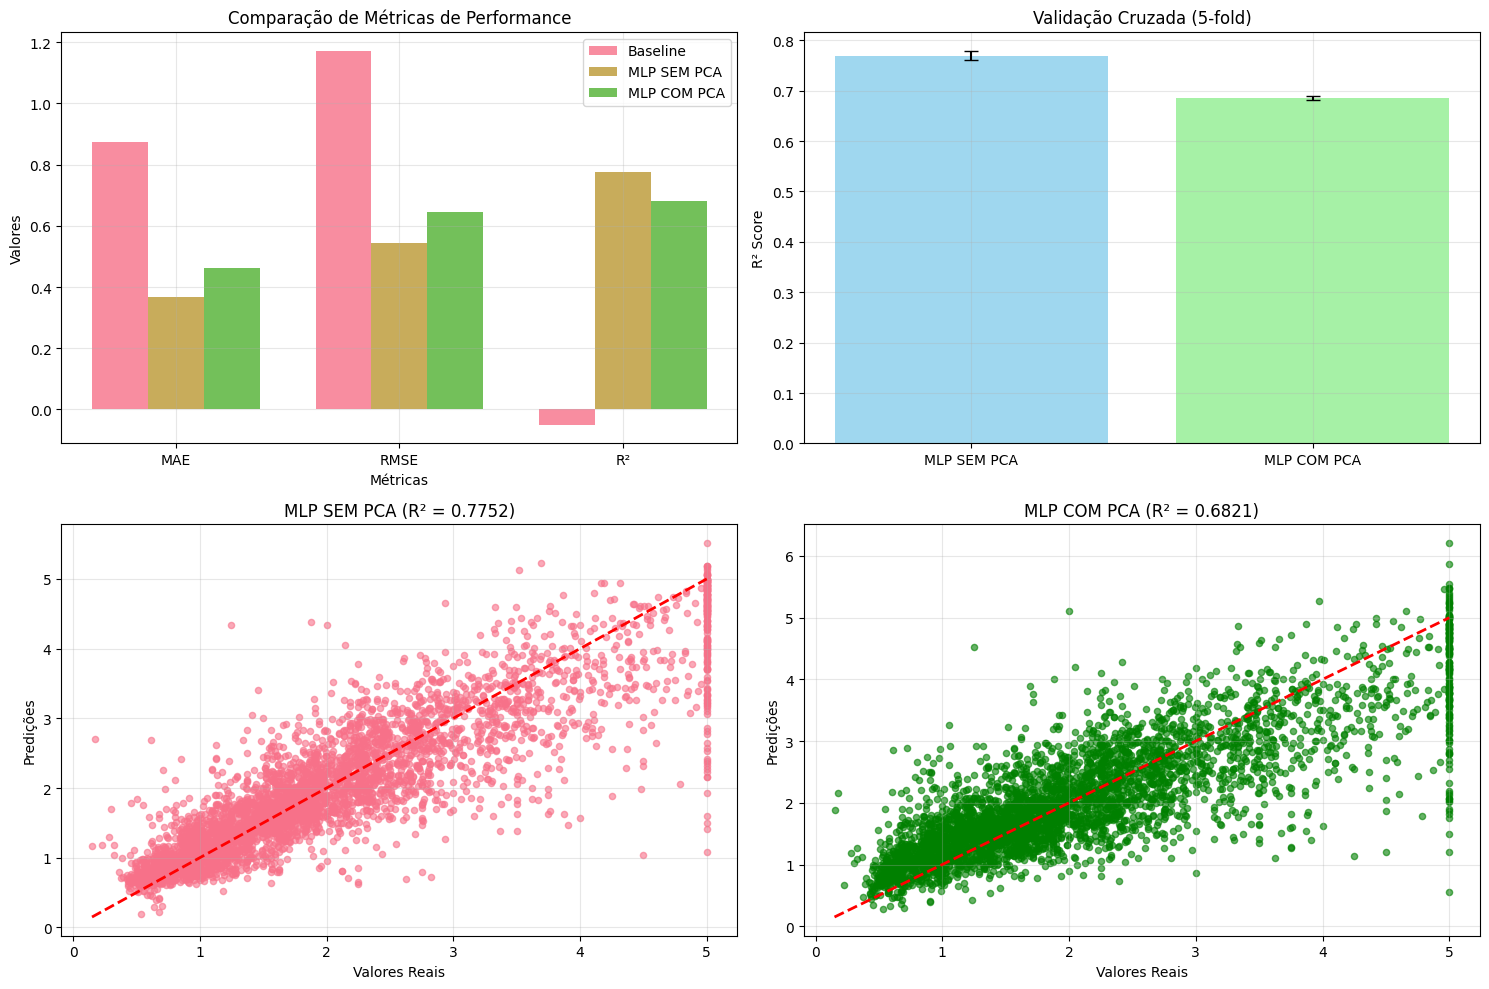


🔍 ANÁLISE DE DIMENSIONALIDADE:
- Features originais: 8
- Features após PCA: 6
- Redução: 25.0%
- Variância mantida: 95%

📝 CONCLUSÕES:
⚠️  PCA não melhorou significativamente a performance
   - R²: 0.7752 (sem PCA) vs 0.6821 (com PCA)

💡 BENEFÍCIOS DO PCA:
- Redução de 8 para 6 features
- Menor complexidade computacional
- Possível redução de overfitting
- Manutenção de 95% da variância dos dados


In [7]:
# ======================================================
# 7) Comparação Detalhada e Análise de Resultados
# ======================================================

print("\n" + "=" * 60)
print("RESUMO COMPARATIVO DOS RESULTADOS")
print("=" * 60)

# Criar DataFrame com resultados
results_df = pd.DataFrame({
    'Modelo': ['Baseline (Dummy)', 'MLP SEM PCA', 'MLP COM PCA'],
    'MAE': [0.8740, metrics_without_pca['MAE'], metrics_with_pca['MAE']],
    'RMSE': [1.1731, metrics_without_pca['RMSE'], metrics_with_pca['RMSE']],
    'R²': [-0.0502, metrics_without_pca['R2'], metrics_with_pca['R2']],
    'CV R² (média)': ['N/A', f"{cv_scores_without_pca.mean():.4f}", f"{cv_scores_with_pca.mean():.4f}"],
    'CV R² (std)': ['N/A', f"{cv_scores_without_pca.std():.4f}", f"{cv_scores_with_pca.std():.4f}"]
})

print(results_df.to_string(index=False))

# Análise de melhoria
mae_improvement = ((metrics_without_pca['MAE'] - metrics_with_pca['MAE']) / metrics_without_pca['MAE']) * 100
rmse_improvement = ((metrics_without_pca['RMSE'] - metrics_with_pca['RMSE']) / metrics_without_pca['RMSE']) * 100
r2_improvement = ((metrics_with_pca['R2'] - metrics_without_pca['R2']) / abs(metrics_without_pca['R2'])) * 100

print(f"\n📊 ANÁLISE DE MELHORIA COM PCA:")
print(f"- MAE: {mae_improvement:+.2f}%")
print(f"- RMSE: {rmse_improvement:+.2f}%")
print(f"- R²: {r2_improvement:+.2f}%")

# Visualização dos resultados
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Comparação de métricas
metrics_comparison = ['MAE', 'RMSE', 'R²']
baseline_values = [0.8740, 1.1731, -0.0502]
mlp_without_pca = [metrics_without_pca['MAE'], metrics_without_pca['RMSE'], metrics_without_pca['R2']]
mlp_with_pca = [metrics_with_pca['MAE'], metrics_with_pca['RMSE'], metrics_with_pca['R2']]

x = np.arange(len(metrics_comparison))
width = 0.25

axes[0, 0].bar(x - width, baseline_values, width, label='Baseline', alpha=0.8)
axes[0, 0].bar(x, mlp_without_pca, width, label='MLP SEM PCA', alpha=0.8)
axes[0, 0].bar(x + width, mlp_with_pca, width, label='MLP COM PCA', alpha=0.8)
axes[0, 0].set_xlabel('Métricas')
axes[0, 0].set_ylabel('Valores')
axes[0, 0].set_title('Comparação de Métricas de Performance')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_comparison)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Validação Cruzada
cv_models = ['MLP SEM PCA', 'MLP COM PCA']
cv_means = [cv_scores_without_pca.mean(), cv_scores_with_pca.mean()]
cv_stds = [cv_scores_without_pca.std(), cv_scores_with_pca.std()]

axes[0, 1].bar(cv_models, cv_means, yerr=cv_stds, capsize=5, alpha=0.8, color=['skyblue', 'lightgreen'])
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('Validação Cruzada (5-fold)')
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Predições vs Valores Reais (MLP SEM PCA)
y_pred_without_pca = model_without_pca.predict(X_test)
axes[1, 0].scatter(y_test, y_pred_without_pca, alpha=0.6, s=20)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Valores Reais')
axes[1, 0].set_ylabel('Predições')
axes[1, 0].set_title(f'MLP SEM PCA (R² = {metrics_without_pca["R2"]:.4f})')
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Predições vs Valores Reais (MLP COM PCA)
y_pred_with_pca = model_with_pca.predict(X_test)
axes[1, 1].scatter(y_test, y_pred_with_pca, alpha=0.6, s=20, color='green')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Valores Reais')
axes[1, 1].set_ylabel('Predições')
axes[1, 1].set_title(f'MLP COM PCA (R² = {metrics_with_pca["R2"]:.4f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análise de dimensionalidade
print(f"\n🔍 ANÁLISE DE DIMENSIONALIDADE:")
print(f"- Features originais: {X_train.shape[1]}")
print(f"- Features após PCA: {n_components_optimal}")
print(f"- Redução: {((X_train.shape[1] - n_components_optimal) / X_train.shape[1]) * 100:.1f}%")
print(f"- Variância mantida: 95%")

# Conclusões
print(f"\n📝 CONCLUSÕES:")
if metrics_with_pca['R2'] > metrics_without_pca['R2']:
    print("✅ PCA MELHOROU a performance do modelo!")
    print(f"   - R² aumentou de {metrics_without_pca['R2']:.4f} para {metrics_with_pca['R2']:.4f}")
else:
    print("⚠️  PCA não melhorou significativamente a performance")
    print(f"   - R²: {metrics_without_pca['R2']:.4f} (sem PCA) vs {metrics_with_pca['R2']:.4f} (com PCA)")

print(f"\n💡 BENEFÍCIOS DO PCA:")
print(f"- Redução de {X_train.shape[1]} para {n_components_optimal} features")
print(f"- Menor complexidade computacional")
print(f"- Possível redução de overfitting")
print(f"- Manutenção de 95% da variância dos dados")


In [8]:
# ======================================================
# 8) Salvando Artefatos e Resultados
# ======================================================

# Criar diretório para salvar resultados
os.makedirs("artifacts", exist_ok=True)

# Salvar modelos treinados
joblib.dump(model_without_pca, "artifacts/model_without_pca.joblib")
joblib.dump(model_with_pca, "artifacts/model_with_pca.joblib")

# Salvar métricas comparativas
with open("artifacts/metrics_comparison.txt", "w") as f:
    f.write("COMPARAÇÃO DE MODELOS - CALIFORNIA HOUSING\n")
    f.write("=" * 50 + "\n\n")
    
    f.write("MODELO SEM PCA:\n")
    for k, v in metrics_without_pca.items():
        f.write(f"  {k}: {v:.4f}\n")
    f.write(f"  CV R² (média): {cv_scores_without_pca.mean():.4f}\n")
    f.write(f"  CV R² (std): {cv_scores_without_pca.std():.4f}\n\n")
    
    f.write("MODELO COM PCA:\n")
    for k, v in metrics_with_pca.items():
        f.write(f"  {k}: {v:.4f}\n")
    f.write(f"  CV R² (média): {cv_scores_with_pca.mean():.4f}\n")
    f.write(f"  CV R² (std): {cv_scores_with_pca.std():.4f}\n\n")
    
    f.write("ANÁLISE DE DIMENSIONALIDADE:\n")
    f.write(f"  Features originais: {X_train.shape[1]}\n")
    f.write(f"  Features após PCA: {n_components_optimal}\n")
    f.write(f"  Redução: {((X_train.shape[1] - n_components_optimal) / X_train.shape[1]) * 100:.1f}%\n")
    f.write(f"  Variância mantida: 95%\n\n")
    
    f.write("MELHORIA COM PCA:\n")
    f.write(f"  MAE: {mae_improvement:+.2f}%\n")
    f.write(f"  RMSE: {rmse_improvement:+.2f}%\n")
    f.write(f"  R²: {r2_improvement:+.2f}%\n")

# Salvar DataFrame de resultados
results_df.to_csv("artifacts/results_comparison.csv", index=False)

print("✅ Artefatos salvos em ./artifacts:")
print("   - model_without_pca.joblib")
print("   - model_with_pca.joblib")
print("   - metrics_comparison.txt")
print("   - results_comparison.csv")

print(f"\n🎯 RESUMO FINAL:")
print(f"   - Baseline R²: -0.0502")
print(f"   - MLP SEM PCA R²: {metrics_without_pca['R2']:.4f}")
print(f"   - MLP COM PCA R²: {metrics_with_pca['R2']:.4f}")
print(f"   - Redução dimensional: {((X_train.shape[1] - n_components_optimal) / X_train.shape[1]) * 100:.1f}%")


✅ Artefatos salvos em ./artifacts:
   - model_without_pca.joblib
   - model_with_pca.joblib
   - metrics_comparison.txt
   - results_comparison.csv

🎯 RESUMO FINAL:
   - Baseline R²: -0.0502
   - MLP SEM PCA R²: 0.7752
   - MLP COM PCA R²: 0.6821
   - Redução dimensional: 25.0%
